# Chapter 6: Distributions #
&copy; 2021 Kenneth Winston

We noted at the beginning of Chapter 4 that Louis Bachelier's 1900 PhD thesis was far ahead of its time in its use of Brownian motion to model changes in financial markets. The basic assumption of Gaussian/normal (or lognormal) changes in financial values seems plausible, and many subsequent modelers simply assumed normality.

There's a reason why normality seems, well, normal: the [Central Limit Theorem](#central_limit_theorem), which says that averages of reasonably well-behaved distributions eventually start to look Gaussian. So if (say) one-second changes in logarithms of prices are generated by reasonably well-behaved distributions that satisfy the conditions of the [Central Limit Theorem](#central_limit_theorem), then one-day log-price changes might start to look normal. Indeed, a histogram of log-price changes usually will have the roughly unimodal, symmetric, bell-shaped look of a Gaussian.

But empiricists[$^1$](#six_footnotes) soon began to notice that price changes were too "peaked" to be samples of a normal distribution. Here "peaked" means that very small and very large changes happen far more frequently than a normal distribution would predict, while middling changes happen less frequently. Distributions in which large changes happen more often than in a Gaussian are called **`fat-tailed`**. If the [Central Limit Theorem](#central_limit_theorem) fails empirically, then the component distributions must not be well-behaved in the way the [Central Limit Theorem](#central_limit_theorem) requires.

<a name="mandlebrot"></a>In 1963, [Benoit Mandlebrot](https://www.jstor.org/stable/2350970) analyzed changes in prices of cotton and concluded that [stable distributions](#stable_distributions) with infinite variances gave better explanations of sample behavior than normal distributions. The [Central Limit Theorem](#central_limit_theorem) requires the component distributions to have finite variances, but Mandlebrot thought that this condition was violated.

Most current financial economists think Mandlebrot was right about non-normality, but was wrong about the reason for it. The condition that is currently thought to be the culprit is independence: every second's log-price increment must be independent of every other second's log-price increment for the [Central Limit Theorem](#central_limit_theorem) to apply. If increments aren't independent, then behavior very much like observed behavior can occur.

We'll discuss two fat-tailed distributions that are often used to generate more realistic patterns than a normal distribution: Student's T and a mixture of normals.

We will also discuss extreme value distributions, which are fat-tailed and which are particularly helpful for modeling peril-type risks.

## 6.1 Central Limit Theorem
<a name="central_limit_theorem"></a>

There are many versions of the **`Central Limit Theorem ("CLT")`**. What they have in common is the idea that in the limit, the average of ever-larger numbers of distributions is distributed normally. The distributions being averaged must be independent, and some of their moments must be finite.

For example, if a fair coin is tossed once, the distribution is binary: $50\%$ heads and $50\%$ tails. But if the coin is tossed twice, the distribution is $25\%$ for two heads, $50\%$ for one head and one tail, and $25\%$ for two tails. After only two tosses, there is a rise in the central probabilities and a falling off in probability at the tails.

By the time the coin is tossed $1000$ times, the distribution of the number of heads looks very much like a normal distribution. Further, the more times the coin is tossed, the more probability mass squeezes toward the center: the standard deviation of $n$ uncorrelated fair coin tosses is $\sqrt{n}/2$. Let $P$ be a $\$1$ billion portfolio made up of $n$ uncorrelated risky ventures each like Chapter 2's Beyond Vegetables. Then $P$'s dollar standard deviation will be $10^9/(2\sqrt{n})$, which will tend to zero as $n$ tends to infinity. (But as we noted in Chapter 5, putting together larger and larger numbers of assets into a portfolio does not actually result in standard deviation tending to zero. That in turn means there must be the types of common factors we studied in Chapter 5, so as a practical matter it is impossible to find a large number of uncorrelated assets.)

Figure 6.1 draws the 1000-toss binomial distribution's probability mass function together with a normal probability density function with the same mean (500 heads) and variance (250). It's very hard to see any difference:

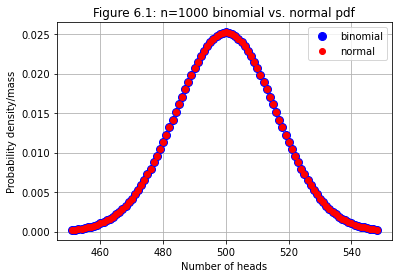

In [1]:
#Compare 1000 coin tosses to a normal distribution
import scipy.stats as spst
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n, p = 1000, 0.5
mean, var, skew, kurt = spst.binom.stats(n, p, moments='mvsk')
x = np.arange(spst.binom.ppf(0.001, n, p),
               spst.binom.ppf(0.999, n, p))
plt.plot(x, spst.binom.pmf(x, n, p), 'bo', ms=8, label='binomial')
plt.plot(x, spst.norm.pdf(x, loc=mean, scale=np.sqrt(var)), 'ro', label='normal')
plt.title('Figure 6.1: n=1000 binomial vs. normal pdf')
plt.xlabel('Number of heads')
plt.ylabel('Probability density/mass')
plt.legend(loc='best')
plt.grid(True)
plt.show();

More formally, we have the following version[$^2$](#six_footnotes) of the CLT:
><u>**Central Limit Theorem (Lyapunov-Lindeberg)**</u>. Let $\{X_i\}$ be a discrete scalar stochastic process where each pair $\{X_i,X_j\}$ is independent. Suppose each mean $\mu_i=\mathbb{E}[X_i]$ and each variance $\sigma_i^2=\mathbb{E}[(X_i-\mu_i)^2]$ is defined and finite. Define $s_n^2=\sum_{i=1}^n\sigma_i^2$, and suppose that
$$\lim_{n\to\infty}\frac{1}{s_n^2}\sum_{i=1}^n\mathbb{E}[(X_i-\mu_i)^2 \delta(|X_i-\mu_i|>\epsilon s_n)]=0\quad\forall \epsilon>0\label{eq:lindeberg_condition}\tag{6.1}$$
where $\delta(b)=1$ if $b$ is true and $\delta(b)=0$ otherwise. Then if we define the standardized average
$$Z_n=\frac{\sum_{i=1}^n{\bigl(X_n-\mu_n\bigr)}}{s_n}\label{eq:lyapunov_zscore}\tag{6.2}$$
and if $F_{Z_n}(x)$ is the cumulative distribution function of $Z_n$, we have
$$\lim_{n\to\infty}F_{Z_n}(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^x{\exp\bigl(-\frac{t^2}{2}\bigr)dt}=F_{Norm}(x)\quad\forall x\in\mathbb{R}\label{eq:lyapunov_limit}\tag{6.3}$$

The often-cited Lindeberg-Levy form of the CLT requires **`independent and identically distributed (iid)`** $X_i$. The Lyapunov-Lindeberg form only requires independence; finite first and second moments, and the technical "Lindeberg Condition" \eqref{eq:lindeberg_condition}, which essentially says that the contributions to overall variance coming from the tails of the distributions have to become negligible as $n\to\infty$.

For example, we could take second-by-second observations of the percentage price changes of the Swiss Franc ("Swissie") vs. the dollar. We don't even need to know what distributions are generating these observations: we could be in a state of Knightian Uncertainty. Each second's distribution could be different from the next second's distribution. All we need to know is that each second is independent of each other second; that whatever distributions are generating these price changes don't "go crazy" with infinite moments; and that each second's variance is a small component of the overall variance, as required by \eqref{eq:lindeberg_condition}. Currencies trade in New York, London, Tokyo, Hong Kong and other venues - say roughly 16 active hours during a day, or 57,600 seconds. If the conditions of the CLT are satisfied, then it's plausible that daily price changes of the Swissie should look normal.

In fact under conditions similar to those of the CLT, the Berry-Esseen Theorem[$^3$](#six_footnotes) specifies a rate of convergence:
><u>**Berry-Esseen Theorem**</u> Let $\{X_i\}$ be a discrete scalar stochastic process where each pair $\{X_i,X_j\}$ is independent. Suppose each mean $\mu_i=\mathbb{E}[X_i]$ and each variance $\sigma_i^2=\mathbb{E}[(X_i-\mu_i)^2]$ is defined and finite. Let $s_n^2$, $Z_n$, $F_{Z_n}(x)$, and $F_{Norm}(x)$ be as defined in the CLT. Then there is a constant $C_0$ so that
$$\sup_{x\in\mathbb{R}}|F_{Z_n}(x)-F_{Norm}(x)|\leq \frac{C_0}{\sqrt{n}} \frac{\bar{\rho_n}}{\bar{s_n}^3}\label{eq:berry-esseen}\tag{6.4}$$
where $\bar{s}_n^2=\frac{1}{n}s_n^2$ and $\bar{\rho_n}=\frac{1}{n}\sum_{i=1}^n\mathbb{E}[|X_i-\mu_i|^3]$. 

Upper bounds on the constant $C_0$ have been improved gradually since the original publication of the theorem in 1942. In 2010 [Irina Shevtsova](https://doi.org/10.1134%2FS1064562410060062) proved that $C_0<.5600$ for all $n$, with smaller upper bounds on $C_0$ for $n\leq10$.

Note that $\bar{\rho_n}$ is the average absolute third moment and $\bar{s}_n^2$ is the average second moment. If the component distributions are i.i.d. normal with common mean $\mu$ and common standard deviation $\sigma$, then the common absolute third moment is
$$\rho=\frac{2}{\sqrt{2\pi}\sigma}\int_{\mu}^{\infty}{(x-\mu)^3\exp\bigl(-\frac{(x-\mu)^2}{2\sigma^2}\bigr)dx}=\frac{2}{\sqrt{2\pi}\sigma}\int_0^{\infty}{2^{3/2}\sigma^3y^{3/2}\exp(-y)\frac{\sigma^2dy}{\sqrt{2y}\sigma}}=\frac{4\sigma^3}{\sqrt{2\pi}}$$
using the change of variable $y=\frac{(x-\mu)^2}{2\sigma^2}$. If we take the ratio $Ratio_{\{X_i\}}=\sup_{n}\frac{\bar{\rho_n}}{\bar{s_n}^3}$ as a tail thickness measure of the stochastic processes $\{X_i\}$, the i.i.d. normal baseline value is $Ratio_{Norm}=\frac{4}{\sqrt{2\pi}}\approx1.596$. If we can find an upper bound of the form $Ratio_{\{X_i\}}\leq Ratio_{Norm}*k$, then Berry-Esseen will give us a rate of convergence for the composite distributions $F_{Z_n}(x)$.

For example, if we have a log-price process $\{X_i\}$ where $Ratio_{\{X_i\}}\leq Ratio_{Norm}*2$, then we know from \eqref{eq:berry-esseen} that by the time there are $n=10,000$ observations, the composite distribution $F_{Z_n}(x)$ will be everywhere less than $2\cdot.5600\cdot\frac{4}{100\sqrt{2\pi}}\approx1.8\%$ away from the normal cdf $F_{Norm}(x)$.

### 6.1.1 Checking Normality: Q-Q and P-P Plots
<a name='q_q_plots'></a>

There is a way to demonstrate visually whether or not a sample has been drawn from a particular distribution: a **`Q-Q (quantile-quantile) plot`**. The idea is to sort the sample observations so that $x_1\leq\dots\leq x_n$. We form standardized observations $z_i=\frac{x_i-m}{s}$, where $m=\frac{1}{n}\sum_{i=1}^n x_i$ is the sample mean and $s^2=\frac{1}{n}\sum_{i=1}^n (x_i-m)^2$ is the sample variance. If these were distributed according the cdf $F(x)$, then we could approximate $z_i$ with the inverse distribution function
$$z_i\approx F^{-1}\bigl(\frac{i}{n+1}\bigr)\label{eq:qqplot}\tag{6.5}$$
That is, $F(z_i)\approx\frac{i}{n+1}$. A Q-Q plot is a scatter of $n$ points whose $(x,y)$ coordinates are $(F^{-1}\bigl(\frac{i}{n+1}\bigr),z_i)$. If the sample is close to the desired distribution, then the Q-Q plot should be close to a straight line.

Let's try this for the Swissie; our desired distribution is normal, $F_{Norm}(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^x\exp\bigl(-\frac{t^2}{2}\bigr)dt$ as in \eqref{eq:lyapunov_limit}. The observations will be daily log-changes of the Swissie from 1971 to the end of last year.

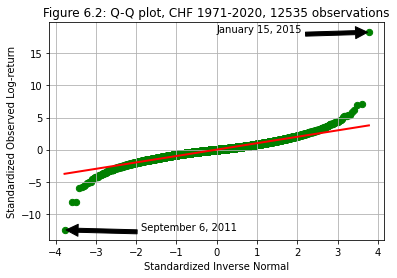

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import qrpm_funcs as qf
#Get 3 currencies until the end of previous year.

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)
multipliers=[-1,1,-1]
lgdates,difflgs=qf.levels_to_log_returns(cdates,ratematrix,multipliers)      
        
#Make the Q-Q plot of Swiss francs
chf=[row[0] for row in difflgs]
mean_chf=np.mean(chf)
stdev_chf=np.std(chf)
nobs_chf=len(chf)

#Plot the diagonal
x=spst.norm.ppf([i/(nobs_chf+1) for i in range(1,nobs_chf+1)])
line=plt.plot(x, x)
plt.setp(line, linewidth=2, color='r')

#Plot the actuals
y=np.sort(np.array((chf-mean_chf)/stdev_chf))
plt.scatter(x, y, s=40, c='g')

#Find positive outlier
bigplus=max(y)
plt.annotate('January 15, 2015', xy=(max(x), bigplus), xytext=(0, bigplus),
            arrowprops=dict(facecolor='black', shrink=0.02),)

#Find negative outlier
bigminus=min(y)
plt.annotate('September 6, 2011', xy=(min(x), bigminus), xytext=(.5*min(x), bigminus),
            arrowprops=dict(facecolor='black', shrink=0.02),)

# Configure the graph
plt.title('Figure 6.2: Q-Q plot, CHF '+lgdates[0][:4]+'-'+lastday[:4]+ \
          ', '+str(nobs_chf)+' observations')
plt.xlabel('Standardized Inverse Normal')
plt.ylabel('Standardized Observed Log-return')
plt.grid(True)
plt.show;

The red straight line shows what Figure 6.2 would look like if Swissie observations were sampled from a normal distribution. They clearly weren't: the green line formed from actual Swissie data is fairly straight in the middle, but begins to curve noticeably away from the red line at about $\pm2.5$ standard deviations. This is a typical fat-tailed ([leptokurtic](#kurtosis)) pattern seen in financial data.

Note for example the more than 12 standard deviation fall of the Swissie (versus the US dollar) in the lower left of the graph. That was on September 6, 2011 when the Swiss National Bank (the [central bank](#central_banking) of Switzerland) announced that they would do [whatever it took](http://www.theguardian.com/business/2011/sep/06/switzerland-pegs-swiss-franc-euro) to devalue the Swissie, effectively pegging it to the cheaper Euro. They felt this was necessary because they were getting less and less competitive, losing out to goods and services denominated in Euros on world markets.

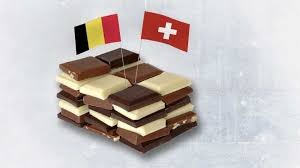

As we will see below, the chance of a 12+ standard deviation move under the assumption of a normal distribution is essentially nil.

On January 15, 2015 the SNB announced that they were [abandoning the ceiling](http://money.cnn.com/2015/01/15/investing/switzerland-euro-currency-ceiling/) on the Swissie’s value and it shot up by 18 standard deviations, an even more improbable chance than before.

When the inverse $F^{-1}$ of the target cdf $F$ is not easily computed, a **`P-P (probability-probability) plot`** can be used. The scatter points have $(x,y)$ coordinates equal to $(\bigl(\frac{i}{n+1}\bigr),F(z_i))$. For the Swissie data, the P-P plot looks like this:

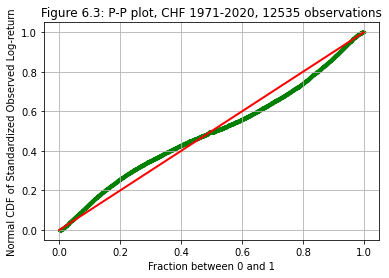

In [3]:
#Make the P-P plot of Swiss francs
x=[i/(nobs_chf+1) for i in range(1,nobs_chf+1)]
#Plot the diagonal
line=plt.plot(x, x)
plt.setp(line, linewidth=2, color='r')
#Plot the actuals
y=np.sort(np.array(spst.norm.cdf((chf-mean_chf)/stdev_chf)))
plt.scatter(x, y, s=5, c='g')
## Configure the graph
plt.title('Figure 6.3: P-P plot, CHF '+lgdates[0][:4]+'-'+lastday[:4]+ \
          ', '+str(nobs_chf)+' observations')
plt.xlabel('Fraction between 0 and 1')
plt.ylabel('Normal CDF of Standardized Observed Log-return')
plt.grid(True)
plt.show;

The scatter plot's departure from the target normal distribution is less visually striking in Figure 6.3 than it was in Figure 6.2, but the departure is still present. The fact that the green scatter goes above the red diagonal line in the left half of the figure shows that the empirical distribution initially accumulates probability in the below-median region faster than the normal distribution. That's another way of saying that the normal distribution stochastically dominates the empirical distribution below the median. Above the median, the empirical distribution dominates. In both cases, that's because of fatter tails in the empirical distribution.

### 6.1.2 Jarque-Bera

A more metrical approach to characterizing normality or non-normality is the [Jarque-Bera test](https://doi.org/10.1016%2F0165-1765%2880%2990024-5). This starts from the observation that a normal distribution has zero skewness (third moment) and excess [kurtosis](#kurtosis) ($\equiv$kurtosis minus 3):
$$\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}t^3\exp\bigl(-\frac{t^2}{2}\bigr)dt=0;\quad\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}t^4\exp\bigl(-\frac{t^2}{2}\bigr)dt=3\label{eq:jarque_bera_normal}\tag{6.6}$$

The Jarque-Bera test forms a statistic that gets larger as S=skewness and K=(excess [kurtosis](#kurtosis)) depart from zero. This statistic is distributed as chi-squared with two degrees of freedom (scipy.stats.chi2.cdf(x,2)), and gives the probability that the observed distribution is non-normal:
$$JB(S,K)=\frac{n}{6}\bigl(S^2+K^2/4\bigr)\label{eq:jarque_bera_stat}\tag{6.7}$$

For the Swissie series from 1971 through the previous yearend, visual inspection of Figure 6.2 indicated the data is significantly non-normal. This is confirmed by Jarque-Bera:

In [5]:
#Jarque-Bera
sk=spst.skew(chf)
ku=spst.kurtosis(chf)    #This gives excess kurtosis
jb=(nobs_chf/6)*(sk**2+(ku**2)/4)
chi2=spst.chi2.cdf(jb,2)
print('Skewness %f' % sk)
print('Excess Kurtosis %f' % ku)
print('Jarque-Bera Statistic %f' % jb)
print('Chi-squared probability non-normal %f' % chi2)

Skewness 0.395708
Excess Kurtosis 14.354852
Jarque-Bera Statistic 107951.476252
Chi-squared probability non-normal 1.000000


The null hypothesis is that the data is normal; we reject that hypothesis when the chi-squared statistic is above a desired confidence level. For the Swissie data, there is almost perfect confidence in rejecting normality.

### 6.1.3 Causes of non-normality ###

There are at least two phenomena causing the departures from normality reflected in Figure 6.2 and the Jarque-Bera statistic. One is the presence of a large price-maker in the market. The dynamic behind Brownian motion is a series of random collisions of molecules (the equivalent of comparatively small price-takers) moving the location of a particle (the price of the Swissie). If the scientist looking at the particle under the microscope picks up the slide it's on and moves it across the laboratory, that's an intervention on a massively greater scale than random molecule collisions. That's what the Swiss National Bank did on the two highlighted extreme dates.

But even leaving aside the SNB's interventions, there are a good number of observations of regular market days that curve away from the straight (normal) line in Figure 6.2. This empirical failure of the Central Limit Theorem &mdash; significant leptokurtosis &mdash; appears in virtually every financial time series. [Mandlebrot's explanation](#mandlebrot) was essentially that any second could have an arbitrarily large price move, but that doesn't seem consistent with the data. A more reasonable failure point for the Central Limit Theorem's assumptions is independence: there can be periods of systematic trending, so the second-by-second observations don't cancel each other out but rather reinforce each other.

There is a limit to how much weight can be in the tails of a distribution. **`Markov's Inequality`** says that if $Z$ is a non-negative random variable, then
$$Pr\bigl(Z>k\mathbb{E}[Z]\bigr)\leq\frac{1}{k}\label{eq:markov_inequality}\tag{6.8}$$
If $X$ is any random variable with finite first and second moments, then letting $Z=(X-\mathbb{E}[X])^2$ and applying \eqref{eq:markov_inequality} with $\sigma=\mathbb{E}[Z]=\mathbb{E}[(X-\mathbb{E}[X])^2]$ proves **`Chebyshev's Inequality`**:[$^4$](#six_footnotes)
$$Pr\bigl(|X-\mathbb{E}[X]|\geq k\sigma\bigr)\leq\frac{1}{k^2}\label{eq:chebyshev_inequality}\tag{6.9}$$
This says that the probability of being k standard deviations $\sigma$ away from the mean can be no more than $\frac{1}{k^2}$. Thus a 10 standard deviation event can happen no more than 1/100th of the time. That’s about 2.5 times a year assuming daily periodicity. For a normal distribution, 10 standard deviation events are a lot rarer, as shown in the following Table 6.1:<a name="normal_probabilities"></a>

In [87]:
#Normal distribution probabilities
from tabulate import tabulate

out_table = [['%3.0f' % i,'%15.9f' % np.log10(spst.norm.cdf(-i))] for i in range(21)]
headers=['Std. Devs','log10(prob)']

print('Table 6.1: Normal distribution probabilities (log10)')
print(tabulate(out_table, headers, tablefmt='fancy_grid'))

Table 6.1: Normal distribution probabilities (log10)
╒═════════════╤═══════════════╕
│   Std. Devs │   log10(prob) │
╞═════════════╪═══════════════╡
│           0 │     -0.30103  │
├─────────────┼───────────────┤
│           1 │     -0.799546 │
├─────────────┼───────────────┤
│           2 │     -1.64302  │
├─────────────┼───────────────┤
│           3 │     -2.8697   │
├─────────────┼───────────────┤
│           4 │     -4.49933  │
├─────────────┼───────────────┤
│           5 │     -6.54265  │
├─────────────┼───────────────┤
│           6 │     -9.00586  │
├─────────────┼───────────────┤
│           7 │    -11.8929   │
├─────────────┼───────────────┤
│           8 │    -15.2061   │
├─────────────┼───────────────┤
│           9 │    -18.9475   │
├─────────────┼───────────────┤
│          10 │    -23.1181   │
├─────────────┼───────────────┤
│          11 │    -27.7188   │
├─────────────┼───────────────┤
│          12 │    -32.7504   │
├─────────────┼───────────────┤
│          13 │    

Table 6.1 shows 10 standard deviation events expected to occur in one per $10^{-23}$ periods. The age of the universe[$^5$](#six_footnotes) is less than $10^{13}$ business days, so anything over about 8 standard deviations is effectively never, assuming normality. The fact of the 18 standard deviation event ($10^{-72}$ frequency) in Swissie prices on January 15, 2015 is by itself excellent evidence for non-normality. On the other hand, Chebyshev's Inequality says such events could happen every 324 days &mdash; once per 1.3 years of business days. Observed data seems to be well within Chebyshev's bound but well outside normal.

The apparent violation of the Central Limit Theorem's independence condition is due to the fact that financial markets are populated with humans who react to patterns they perceive in history. We've seen that general idea [expressed in many different ways](#caveat_laws). Reactions can be **`procyclical`** (positively correlated with the past) or **`anticyclical`** (negatively correlated with the past); neither reaction is independent of the past.

### 6.1.4 Market Ages ###

The oldest continuously operating bond market appears to be for British government debt starting around the formation of the [Bank of England in 1694](https://www.bankofengland.co.uk/about/history). The Bank of England has kept track of rates on consols (perpetual bonds) and other long-term borrowings since 1703, as shown in Figure 6.4.

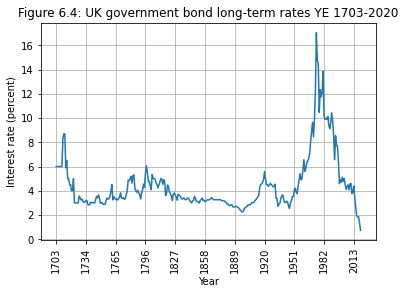

In [7]:
#Get long bond/consol rates from 1703 to present
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as datetime
import qrpm_funcs as qf

lastday=qf.LastYearEnd()

#Get annual and monthly data from Bank of England millenium study
url="https://www.bankofengland.co.uk/-/media/boe/files/statistics/research-datasets"
url+="/a-millennium-of-macroeconomic-data-for-the-uk.xlsx"
sheet1='A31. Interest rates & asset ps '    #Annual data starting 1703
sheet2='M10. Mthly long-term rates'         #Monthly data starting 1753
historical_lt=pd.read_excel(url,engine="openpyxl",sheet_name=[sheet1,sheet2])

#Annual data
dates=[]
rates=[]
for i in range(21,71):
    end_year=str(historical_lt[sheet1].iloc[i][0])+"-12-31"
    dates.append(datetime.datetime.strptime(end_year, "%Y-%m-%d"))
    rates.append(historical_lt[sheet1].iloc[i][19])

#Monthly data
end_days={'Jan': 31, 'Feb': 28, 'Mar': 31, 'Apr': 30, 'May': 31, 'Jun': 30, \
          'Jul': 31, 'Aug': 31, 'Sep': 30, 'Oct': 31, 'Nov': 30, 'Dec': 31}
for i in range(12,len(historical_lt[sheet2])-406):
    end_month=str(historical_lt[sheet2].iloc[i][0])+'-'+historical_lt[sheet2].iloc[i][1]
    end_month+='-'+str(end_days[historical_lt[sheet2].iloc[i][1]])
    dates.append(datetime.datetime.strptime(end_month, "%Y-%b-%d"))
    rates.append(historical_lt[sheet2].iloc[i][10])
    
#Get recent long-term rates from Bank of England (up to end of last year)
#Using format indicated in
#https://www.bankofengland.co.uk/boeapps/database/help.asp?Back=Y&Highlight=CSV#CSV
#20-year rates splice the best with consol data
url="https://www.bankofengland.co.uk/boeapps/database/_iadb-fromshowcolumns.asp?csv.x=yes"
url+="&Datefrom=01/Jan/2016&Dateto=31/Dec/"+lastday[:4]
url+="&SeriesCodes=IUMLNZC&CSVF=TN&UsingCodes=Y"
recent_lt=pd.read_csv(url)

last_historic = dates[-1]
for i in range(len(recent_lt)):
    this_date = datetime.datetime.strptime(recent_lt["DATE"].iloc[i], "%d %b %Y")
    if this_date>last_historic:
        dates.append(this_date)
        rates.append(recent_lt["IUMLNZC"].iloc[i])
        
df_longterm = pd.DataFrame(data={'Date': dates, 'Rate': rates})

df_long_annual = df_longterm.resample('A', on='Date').last()

years = [df_long_annual["Date"].iloc[i].year for i in range(len(df_long_annual))]

#Display plot

n_years = len(df_long_annual)
stride = int(n_years/10)

plt.plot(range(n_years), df_long_annual["Rate"])
plt.xticks(np.arange(0,n_years,stride),years[::stride],rotation='vertical')
str_title='Figure 6.4: UK government bond long-term rates YE '
str_title+=str(df_long_annual["Date"].iloc[0].year)+'-'
str_title+=str(df_long_annual["Date"].iloc[-1].year)
plt.title(str_title)
plt.xlabel('Year')
plt.ylabel('Interest rate (percent)')
plt.grid(True)
plt.show;

Borrowing and lending has been recorded for almost as long as humans have produced records (about 5,000 years[$^6$](#six_footnotes)), but Figure 6.4 documents the world record of over three hundred years of uninterrupted payments from the same non-defaulting entity.

The oldest continuously operating stock exchange in the world is the [Amsterdam Stock Exchange](https://cup.columbia.edu/book/the-worlds-first-stock-exchange/9780231163781), started in 1602.[$^7$](#six_footnotes) 

Otherwise most markets have had lives of less than 200 years.[$^8$](#six_footnotes) Sometimes market failures have been accompanied by a violent break in the political system as well, with loss of life focusing the mind more than loss of investment. The Russian Revolution repudiated all government debt and abolished private property in a series of steps from 1917 to 1920, so once-thriving stock exchanges in Moscow, Kiev and St. Petersburg had total losses of value. The Chinese government took similar steps from 1949 to 1953;[$^9$](#six_footnotes) the Cuban government in 1959.

Thus in modeling empirical finance, it is usually not reasonable to apply a theorem that has $t\to\infty$ somewhere in its proof. $t\to300$ (years) is more realistic. Arguments that depend on long-term equlibrium taking hold are prone to be emphatically disproven by rebels storming the seat of government.

The oldest operating markets have been in existence for about $10^{5}$ days, so if financial data was normally distributed we might expect to see a few 4 or 5 standard deviation events during their entire existence. In fact such events are relatively common. Even in the relatively staid and short 300-plus annual observations of UK rate changes shown in Figure 6.4, there was a 7 standard deviation event and more than 11 observations greater than expected if the data were normal:

In [60]:
#Compute lag-1 differences of long-term UK rate levels
df_diffs=df_long_annual.diff().drop(index=df_long_annual.index[0])

#Standardize
diff_mean=df_diffs["Rate"].mean(axis=0)
diff_std=df_diffs["Rate"].std(axis=0)
df_diffs["Rate"]=(df_diffs["Rate"]-diff_mean)/diff_std

#Find large moves
expected_max=-spst.norm.ppf(1./len(df_diffs))
bigger_count=abs(df_diffs["Rate"])>expected_max
print('Normal standard deviations for one in {} years: {}'.format(len(df_diffs),expected_max))
print('Observations larger than that:')
print(df_diffs[bigger_count].sort_values(by=['Rate'])['Rate'])

Normal standard deviations for one in 317 years: 2.7312662298643744
Observations larger than that:
Date
1977-12-31   -5.895887
1982-12-31   -5.409884
1713-12-31   -4.099149
1975-12-31   -3.318599
1722-12-31   -2.920961
1993-12-31   -2.906233
1978-12-31    2.778526
1994-12-31    2.940527
1710-12-31    3.411803
1973-12-31    3.573804
1974-12-31    7.078914
Name: Rate, dtype: float64


On the other hand, overly violent moves are not compatible with ongoing markets: a primary market with regular 90% swings in value will simply scare away participants. So some kind of intermediate distribution &mdash; more violent than normal, but less violent than an infinite-variance distribution &mdash; is in order.

## 6.2 Student's T Distribution
<a name="students_tdist"></a>

There are many natural distributions that are fatter-tailed than normal. One popular choice to fatten tails is the **`Student's T-distribution`**. The sample means of finite numbers of observations drawn from a normal process are not distributed normally, but rather as a Student's T.

The distribution is generally credited to [William Gosset](http://www-history.mcs.st-andrews.ac.uk/Biographies/Gosset.html), who wrote under the pen-name "Student." In a [1908 article](https://dx.doi.org/10.2307/2331554), he reported on the distribution of the error in estimating the mean from small samples of draws from a normal process. However the distribution was actually known as early as 1876, when it was discovered by [Jacob L&uuml;roth](http://www-history.mcs.st-andrews.ac.uk/Biographies/Lueroth.html). L&uuml;roth's work was in German and was not well known to English statisticians when Student (Gosset) did his work.

The idea is that there are $n$ independent observations $X_1, X_2, \dots, X_n$ of a random variable that is normally distributed with known mean $\mu$, but whose variance is unknown. The observed mean is $m_n=\frac{X_1+X_2+\dots+X_n}{n}$.

An estimate of the unknown variance can be computed from the data in the usual way:
$$s_n^2=\frac{1}{n-1}\sum_{i=1}^n(X_i-m_n)^2\label{eq:sample_stddev}\tag{6.10}$$
The **`Student T-statistic`** is
$$T_{n}=\sqrt{n}\bigl(\frac{m_{n}-\mu}{s_{n}}\bigr)\label{eq:student_t_stat}\tag{6.11}$$
where $n$ is the number of observations. Student (Gosset) computed the pdf of this distribution. The usual presentation defines $d=n-1$ and defines 
$$student_{d}(t)=\frac{\Gamma(\frac{d+1}{2})}{\sqrt{d\pi}\Gamma(\frac{d}{2})}\bigl(1+\frac{t^2}{d}\bigr)^{-\frac{d+1}{2}}\label{eq:student_t_dist}\tag{6.12}$$

<a name="gamma_function"></a>This uses the Gamma function $\Gamma(x)=\int_0^{\infty}e^{-t}t^{x-1}dt$. For integer $i$, $\Gamma(i)=(i-1)!$. From Stirling's formula $\Gamma(x)\approx\sqrt{\frac{2\pi}{x}}\bigl(\frac{x}{e}\bigr)^x$, it follows that the ratio of the Gamma functions in \eqref{eq:student_t_dist} approaches $\sqrt{\frac{d}{2}}$ as $d\to\infty$. Thus we have
$$\lim_{d\to\infty}student_d(t)=\frac{1}{\sqrt{2\pi}}\exp\bigl(-\frac{t^2}{2}\bigr)$$
That is, for large numbers of observations, the Student's T pdf approaches the normal pdf as the Central Limit Theorem dictates.

The standardized Student’s T distribution in \eqref{eq:student_t_dist} has odd moments (including mean and skew) equal to zero; variance equal to $d/(d-2)$; and excess kurtosis equal to $6/(d-4)$ when $d>4$. We can move the mean to a desired quantity $a$ and scale the standard deviation by a desired quantity $b$ by translating and scaling the argument:
$$student_{d,a,b}(t)=student_{d}(\frac{t-a}{b})=\frac{\Gamma(\frac{d+1}{2})}{\sqrt{d\pi}\Gamma(\frac{d}{2})}\bigl(1-\frac{\bigl(\frac{t-a}{b}\bigr)^2}{d}\bigr)^{-\frac{d+1}{2}}\tag{6.13}$$

The code cell shows Student's T pdfs for various low $d$ compared to a near-normal ($d=1000$) pdf:

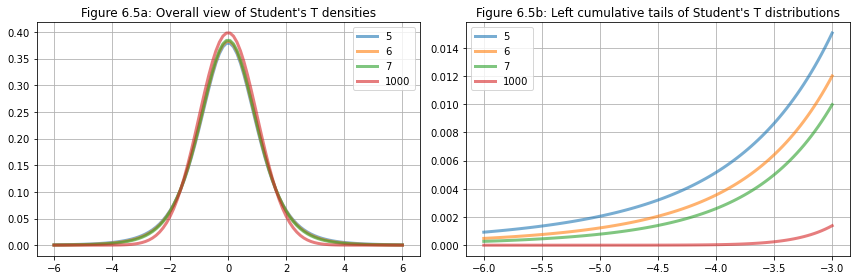

In [61]:
from scipy.stats import t
import matplotlib.pyplot as plt

highend=[6.,-3.]
title_strings=["Figure 6.5a: Overall view of Student\'s T densities",
               "Figure 6.5b: Left cumulative tails of Student\'s T distributions"]
plt.figure(figsize=(12,4))
for sp, top in enumerate(highend):
    plt.subplot(1, 2, sp+1)
    x = np.linspace(-6., top, 100)
    for d in (5,6,7,1000):
        if sp==0:
            plt.plot(x, t.pdf(x, d), lw=3, alpha=0.6, label=str(d))
        else:
            plt.plot(x, t.cdf(x, d), lw=3, alpha=0.6, label=str(d))
    plt.grid()
    plt.legend()
    plt.title(title_strings[sp])

plt.tight_layout()
plt.show();

The first-order visual impression from the left figure (6.4a) is that there is only a slight difference between the distributions. However it becomes apparent when we zoom in on the left tails that there's a huge difference: for example, a four or worse standard deviation event occurs quite rarely (about once in 117 years with daily periodicity) with d=1000. With d=5, the four or worse standard deviation event occurs about once in 9 months.

## 6.3 Mixtures of Normals
<a name="mixtures_of_normals"></a>

A second simple way of fattening tails is to take a **`mixture of normals`**. This is not to be confused with a sum of (independent) normals $S_m=X_1+...+X_m$; the random variable $S_m$ is itself normal.

A mixture distribution adds the probability density functions (or equivalently the cdfs), not the random variables. We will assume that we have a finite number m of distributions to be mixed, and that there are weights $w_1,...,w_m$ with $w_i>0$ and $w_1+...+w_m=1$. Let $\text{pdf}_i()$ be the probability density function of the $i^{th}$ distribution. Then the mixture distribution’s probability density function is:
$$\text{pdf}_{mix}(t)=\sum_{i=1}^m w_i \text{pdf}_i(t)\label{eq:mixture_definition}\tag{6.15}$$
We can think of the mixture distribution as a two-part process: first a variate is sampled from a uniform distribution on the interval $[0,1]$. If the variate is between $\sum_{j=1}^{i-1} w_j$ and $\sum_{j=1}^{i} w_j$, then a second variate is sampled from the distribution given by $\text{pdf}_i$. Intuitively the surprise of not knowing which distribution gives rise to any given sample is what causes fatter tails.

It's hard to come up with an intuition as to why a Student's T distribution should model a real economic object. The many thousands of Swiss franc observations that gave rise to Figure 6.2 were not small samples of normal distributions. On the other hand, it's plausible that a mixture of distributions could explain what we observe: sometimes markets are calm and sometimes they are volatile.

In combining distributions, we will use the $j^{th}$ [central moment](#central_moments) of the $i^{th}$ distribution, namely
$$c_{i,j}=\int (x-\mu_i)^j \text{pdf}_i(x)dx$$
Note $c_{i,0}=1$ and $c_{i,1}=0$ for all $i$. Let $\mu_i$ be the mean of the $i^{th}$ distribution, $\mu_i=\int x\text{ pdf}_i(x)dx$. It follows from \eqref{eq:mixture_definition} that the mean of the mixture distribution equals the weighted average of the component means:
$$\mu_{mix}=\int x\bigl(\sum_{i=1}^m w_i\text{pdf}_i(x)\bigr)dx=\sum_{i=1}^m w_i\bigl(\int x \text{ pdf}_i(x)dx\bigr)=\sum_{i=1}^m w_i\mu_i\label{eq:mixture_mean}\tag{6.16}$$

In general the $k^{th}$ central moment of the mixture $c_{mix,k}$ can be computed by binomial expansion of the terms.
$$c_{mix,k}=\int \bigl(x-\mu_{mix}\bigr)^k\bigl(\sum_{i=1}^m w_i\text{pdf}_i(x)\bigr)dx$$
$$=\sum_{i=1}^m w_i\bigl(\int\bigl((x-\mu_i)+(\mu_i-\mu_{mix})\bigr)^k\text{pdf}_i(x)dx\bigr)$$
$$=\sum_{i=1}^m w_i\int\bigl[\sum_{j=0}^k {k\choose j}(x-\mu_i)^j(\mu_i-\mu_{mix})^{k-j}\bigr]\text{pdf}_i(x)dx$$
$$=\sum_{i=1}^m w_i\bigl[\sum_{j=0}^k {k\choose j}c_{i,j}(\mu_i-\mu_{mix})^{k-j}\bigr]\label{eq:mixture_general_moment}\tag{6.17}$$

Applying \eqref{eq:mixture_general_moment} to the second central moment &mdash; the variance &mdash; we see that
$$\sigma_{mix}^2=\sum_{i=1}^m w_i\bigl[(\mu_i-\mu_{mix})^2+\sigma_i^2\bigr]=\sum_{i=1}^m w_i\bigl[\mu_i^2+\sigma_i^2\bigr]-\mu_{mix}^2\label{eq:mixture_variance}\tag{6.18}$$
From Jensen's Inequality, we see that the mixture variance $\sigma_{mix}^2$ is no less than the weighted average variance of the components.

The mixture's central third moment and its scaled version ([skewness](#central_moments)) look like this:
$$c_{mix,3}=\sigma_{mix}^3 skew_{mix}=\sum_{i=1}^m w_i\bigl[(\mu_i-\mu_{mix})^3+3\sigma_i^2(\mu_i-\mu_{mix})+c_{i,3}\bigr]\label{eq:mixture_skew}\tag{6.19}$$
If the component means are not all the same, then in general there will be nonzero skew even if all the component skews are zero.

The fourth central moment is the unscaled kurtosis:
$$c_{mix,4}=\sigma_{mix}^4 kurt_{mix}$$
$$=\sum_{i=1}^m w_i\bigl[(\mu_i-\mu_{mix})^4+6\sigma_i^2(\mu_i-\mu_{mix})^2+4c_{i,3}(\mu_i-\mu_{mix})+c_{i,4}\bigr]\label{eq:mixture_kurtosis}\tag{6.20}$$

Recall from \eqref{eq:jarque_bera_normal} that the absolute kurtosis of a normal distribution equals 3. But even if all the components of the mixture are zero-skew distributions with the same means, the absolute kurtosis of the mixture will be greater than 3 as long as the component variances are not all the same; this again is a result of Jensen's Inequality.

Financial time series are mostly unimodal. Mixing normals with different means can lead to multimodal distributions. However \eqref{eq:mixture_variance}-\eqref{eq:mixture_kurtosis} show that we can generate a distribution with a desired mean, standard deviation, and kurtosis by mixing normals with the same means and different standard deviations. We will not be able to generate skew in this way, but can usually get realistic skew for a rate-of-return distribution by taking a log-mixture-of-normals distribution. That is, if $X$ is a random variable with a mixture-of-normals distribution, we look at the random variable $Y=exp(X)$.

If we want to generate a mixture-of-normals distribution with mean $\mu$, standard deviation $\sigma$, and excess kurtosis $\kappa$ (and zero skew), we can use just two normal distributions, both with mean $\mu$ and with standard deviations $\sigma_1$ and $\sigma_2$, respectively. Let $r$ be the ratio of the variances, $r=\frac{\sigma_1^2}{\sigma_2^2}$. Substituting into \eqref{eq:mixture_variance} and \eqref{eq:mixture_kurtosis}, we have two equations in three unknowns:
$$\sigma_{mix}^2=\sigma_2^2 (w_1r+1-w_1)$$
$$\kappa_{mix}=\frac{c_{mix,4}}{\sigma_{mix}^4}-3=3\frac{\bigl(w_1r^2+1-w_1\bigr)}{\bigl(w_1r+1-w_1\bigr)^2}-3\label{eq:mixture_of_two}\tag{6.21}$$

The code in the next cell displays excess kurtosis for $r=5,10,15$ and $20$ at different values of $w_1$:

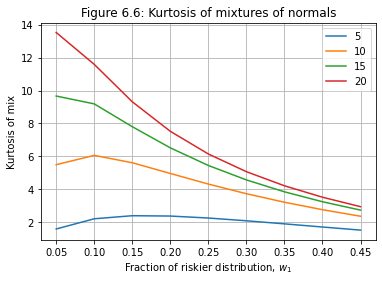

In [64]:
#Generate mixed normal kurtosis graph using formula 6.21

#x contains fractions of the riskier distribution going into the mix
x=np.arange(.05,.5,.05)

#y contains the multiple (how much riskier the riskier distribution is than the less risky)  
y=[5,10,15,20]

z=np.zeros((len(y),len(x)))
for i,multiple in enumerate(y):
    for j,mixamount in enumerate(x):
        #numerator 6.21
        z[i,j] = mixamount*multiple**2
        z[i,j] = mixamount*multiple**2+1-mixamount
        #denominator 6.21
        z[i,j] /= (mixamount*multiple+1-mixamount)**2
        #multiply by 3 and subtract 3
        z[i,j] -= 1
        z[i,j] *= 3
    plt.plot(x,z[i,:],label=str(multiple))

plt.grid()
plt.legend()
plt.xlabel('Fraction of riskier distribution, '+r'$w_1$')
plt.ylabel('Kurtosis of mix')
plt.title('Figure 6.6: Kurtosis of mixtures of normals')
plt.show;

Mixtures of normals are closely related to regime-switching models, such as those in [Ang & Timmerman 2008](https://dx.doi.org/10.2139/ssrn.1919497). As Ang & Timmerman indicate
>Regime-switching models can match the tendency of financial markets to often change their behavior abruptly
and the phenomenon that the new behavior of financial variables often persists for several periods after such a change.

Mixtures of normals get the first part of this – the abrupt changes of behavior – but not the second, i.e. not the persistence of the new behavior. To take that into account, we need time series models such as the ones we will study in Chapter 8.

A more powerful way of fitting large mixtures of normals &mdash; often called Gaussian Mixture Models &mdash; is via a machine learning [expectation maximization technique](https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php). This is a form of unsupervised learning that determines an optimal clustering of a dataset to a best-fit mixture of normals.

## 6.4 Stable Distributions[$^{10}$](#six_footnotes)
<a name="stable_distributions"></a>

We noted above that sums of normal distributions are normal. **`Stable Distributions`** generalize the closed-under-sum property. If $X_1$ and $X_2$ are independent and identically distributed, then their common distribution is **`stable`** if any positive linear combination of $X_1$ and $X_2$ is distributed the same way (up to positive scaling and translation). This class of distributions was characterized by [Paul L&eacute;vy in the 1920s](http://academic2.american.edu/~jpnolan); it's also called L&eacute;vy $\alpha$-stable distributions.

More precisely, a cumulative density function $F(x)$ is stable if and only if when there are two independent random variables $X_1$ and $X_2$, both with cdf's $F(x)$, then for any positive $a$ and $b$ there exists a positive $c$ and a $d$ such that $\frac{aX_1+bX_2}{c}-d$ has cdf equal to $F(x)$.

Stable distributions &mdash; other than the normal distribution, which is in some sense the tamest member of the stable distribution family &mdash; are used sparingly in mathematical finance for two main reasons. One reason is that, other than the normal, stable distributions have undefined variances, making them less likely to describe observed data than fat-tailed but finite-variance distributions. The second reason is more practical: only a few stable distributions have closed-form density functions. Most require an algorithm to compute even the most basic distributional characteristics, like Value at Risk. As we've noted, mathematical modeling in finance is less about finding physical law and more about guiding intuition; that's more difficult to do when the relationship between inputs and outputs is highly nonlinear.

We will briefly cover stable distributions because, as we noted above, [Benoit Mandlebrot](#mandlebrot) proposed them as a way to model the observed leptokurtosis in financial data. Current approaches use more tractable and arguably more realistic techniques, but stable distributions are still good to have in a risk manager's toolkit.

<a name="generalized_clt"></a>
The closed-under-addition property of stable distributions leads to the
>**`Generalized Central Limit Theorem:`** If $X_1, X_2, \dots $ is an infinite sequence of independent and identically distributed variables, and if there are scalar nonstochastic quantities $a_1>0, a_2>0, \dots$ and $b_1, b_2, \dots$ such that the cdfs of $a_n(X_1+X_2+\dots+X_n)-b_n$ converge pointwise to the cdf of a random variable $Z$, then $Z$ is stable. 

The finiteness conditions in the [Central Limit Theorem](#central_limit_theorem) are removed. But the same general conclusion can be drawn: there is a distribution &mdash; or more generally, a family of distribution &mdash; that is the limiting value of some kind of distribution averaging. This is an intuitively reasonable property for financial time series, as it seems desirable to be able to aggregate movements over short time periods into a recognizable distribution over longer periods.

Stable distributions can be specified[$^{11}$](#six_footnotes) with closed-form [characteristic functions](#characteristic_function) using four parameters:

|  Letter  | Parameter name |   &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;          Range                 |
|----------|:-------------:|:------------------------:|
| $\alpha$    | Stability       | $0<\alpha\leq 2$ |
| $\beta$    |  Symmetry        | $-1\leq\beta\leq1$ |
| $\gamma$    |  Scale      | $0<\gamma$ |
| $\delta$    |  Location      | $-\infty<\delta<\infty$ |


Standardized stable distributions can be specified with only the first two parameters ($\alpha$ and $\beta$):
$$\varphi(t)=\exp\bigl(-|t|^{\alpha}\bigl[1-i\beta\tan\bigl(\frac{\pi\alpha}{2}\bigr)sgn(t)\bigr]\bigr),\enspace\alpha\neq1\label{eq:stable_std_alphnot1}\tag{6.30a}$$
$$\varphi(t)=\exp\bigl(-|t|\bigl[1-i\beta\frac{2}{\pi}\ln(|t|)sgn(t)\bigr]\bigr),\enspace\alpha=1\label{eq:stable_std_alph1}\tag{6.30b}$$
sgn(x) is the sign of x (+1 if positive, 0 if 0, -1 if negative). If the distribution is symmetric ($\beta=0$), then the expression for the characteristic function simplifies considerably to $\varphi(t)=\exp(-|t|^{\alpha})$.

The scale parameter (similar to standard deviation) and the location parameter (similar to mean) can be introduced through linear transforms. If $Z$ is a stable random variable whose distribution is given by \eqref{eq:stable_std_alph1}, we can define $X=\gamma Z + \delta$ which by definition is also stable. For the $\alpha\neq1$ case in \eqref{eq:stable_std_alphnot1}, a different transform is used to make the resulting characteristic function a little more tractable: 
$$X=\gamma\bigl(Z-\beta\tan\bigl(\frac{\pi\alpha}{2}\bigr)\bigr)+\delta,\enspace\alpha\neq1\label{eq:stable_transform_alphnot1}\tag{6.31a}$$
$$X=\gamma Z+\delta,\enspace\alpha=1\label{eq:stable_transform_alph1}\tag{6.31b}$$

The characteristic functions of the resulting four-parameter distributions look like this:
$$\varphi(t)=\exp\bigl(-|\gamma t|^{\alpha}\bigl[1-i\beta\tan\bigl(\frac{\pi\alpha}{2}\bigr)sgn(t)(|\gamma t|^{1-\alpha}-1)\bigr]+i\delta t\bigr),\enspace\alpha\neq1\label{eq:stable_full_alphnot1}\tag{6.32a}$$
$$\varphi(t)=\exp\bigl(-|\gamma t|\bigl[1-i\beta\frac{2}{\pi}\ln(|\gamma t|) sgn(t)\bigr]+i\delta t\bigr),\enspace\alpha=1\label{eq:stable_full_alph1}\tag{6.32b}$$
As in the standardized cases \eqref{eq:stable_std_alphnot1} and \eqref{eq:stable_std_alph1}, symmetry considerably simplifies the expression: $\varphi(x)=\exp(-|\gamma t|^{\alpha}+i\delta t)$.

The next cell generates Figures 6.6a and 6.6b, which are similar to 6.4a and 6.4b, except these use stable distributions with different $\alpha$'s. We have included $\alpha=1.7$, which was the value that [Mandlebrot](#mandlebrot) suggested formed a good fit for the cotton price data he analyzed. The differences in tail probabilities are dramatic:

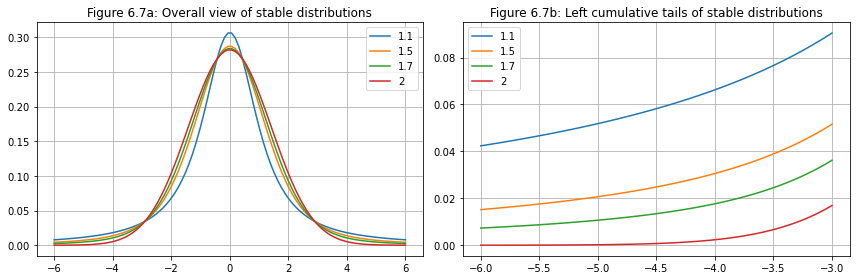

In [65]:
highend=[6.,-3.]
beta = 0     #symmetric
title_strings=["Figure 6.7a: Overall view of stable distributions",
               "Figure 6.7b: Left cumulative tails of stable distributions"]
plt.figure(figsize=(12,4))

for sp, top in enumerate(highend):
    plt.subplot(1, 2, sp+1)
    x = np.linspace(-6., top, 100)
    for alpha in [1.1,1.5,1.7,2]:
        if sp==0:
            plt.plot(x, spst.levy_stable.pdf(x, alpha, beta),
                label=str(alpha))
        else:
            plt.plot(x, spst.levy_stable.cdf(x, alpha, beta),
                label=str(alpha))
    plt.grid()
    plt.legend()
    plt.title(title_strings[sp])
    
plt.tight_layout()
plt.show();

The range of the $\alpha=1.7$ distribution is typically 10-20 times the range of the normal distribution. While financial time series are clearly fat-tailed, they are usually not _that_ fat-tailed. Even the highly unusual events seen in Figure 6.2 as a result of intervention by the Swiss National Bank were only about 3-4 times the range of normal.

There are three standard closed-form pdf's in the stable distribution family. One is when $\alpha=2$; in that case $\tan\bigl(\frac{\pi\alpha}{2}\bigr)=0$, removing the asymmetry terms from \eqref{eq:stable_std_alphnot1}. The characteristic function of the standard stable distribution then inverse-Fourier-transforms to the normal distribution pdf, although with double the variance of the standard normal:
$$f_{\alpha=2}(t)=\frac{1}{2\sqrt{\pi}}\exp\bigl(-\frac{t^2}{4}\bigr)\label{eq:stable_normal_distribution}\tag{6.35}$$

The standard symmetric ($\beta=0$) stable distribution with $\alpha=1$ is called a **`Cauchy distribution`**. In this case \eqref{eq:stable_std_alph1} is simply $\exp(-|t|)$; its inverse Fourier transform is
$$f_{\alpha=1}(t)=\frac{1}{\pi}\frac{1}{1+t^2}\label{eq:cauchy_distribution}\tag{6.36}$$

The stable distribution with $\alpha=\frac{1}{2}$ and $\beta=1$ is called a **L&eacute;vy distribution**. Its pdf looks like:
$$f_{\alpha=\frac{1}{2},\beta=1}(t)=\frac{1}{\sqrt{2\pi t^3}}\exp\bigl(-\frac{1}{2t}\bigr)\label{eq:levy_distribution}\tag{6.37}$$
This can be a little confusing; the entire stable family is sometimes called the "L&eacute;vy $\alpha$-stable" family, but the "L&eacute;vy distribution" is the particular family member given in \eqref{eq:levy_distribution}. The support of this asymmetric pdf consists of the positive real numbers.

The next cell compares these three pdf's, although we have removed the factor of 2 in the normal variance in \eqref{eq:stable_normal_distribution}:

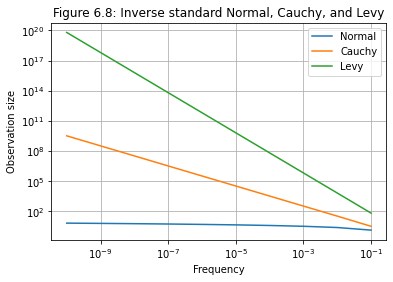

Observation sizes for p=.0001:
Normal: 3.7190164854556804
Cauchy: 3183.098757116829
Levy: 63661976.90343881


In [67]:
#Generate graph comparing standard Cauchy, Levy, and normal densities
p10=np.arange(1,11,1)
x=np.exp(-p10*np.log(10))
ynormal=-spst.norm.ppf(x,0,1)
ycauchy=-spst.cauchy.ppf(x,0,1)
ylevy=spst.levy.ppf(1-x,0,1)

plt.plot(x,ynormal,label='Normal')
plt.plot(x,ycauchy,label='Cauchy')
plt.plot(x,ylevy,label='Levy')

plt.grid()
plt.xscale('log')
plt.xlabel('Frequency')
plt.yscale('log')
plt.ylabel('Observation size')
plt.legend()
plt.title('Figure 6.8: Inverse standard Normal, Cauchy, and Levy')
plt.show();

print('Observation sizes for p=.0001:')
print('Normal:',ynormal[3])
print('Cauchy:',ycauchy[3])
print('Levy:',ylevy[3])

Consider the point $10^{-4}$ on the x axis of Figure 6.8; this represents a frequency that's about once per the number of Swiss franc observations we used for Figure 6.2. The blue line, the normal distribution, shows that observations of size about $\pm 4$ would be expected to be seen that frequently; in fact the straight line in Figure 6.2 is in that vertical range. The red line in Figure 6.8 shows that a Cauchy distribution would produce observations of size $\pm 3183$ once in $10^4$ times. The green line shows that a L&eacute;vy distribution would produce observations of size $63,661,977$ once in $10^4$ times. We noted after Figure 6.7 that $\alpha=1.7$ gave unrealistically fat tails; the Cauchy and L&eacute;vy distributions are even more unrealistic.

It is natural to ask if we can characterize the behavior of tails of distributions, $Pr(X>z)$ or $Pr(X<-z)$ for a random variable $X$ and a large positive scalar $z$. For a standard normal random variable $X$ and $z>0$,
$$Pr(X>z)=\int_{z}^{\infty}f(x)dx<
\int_{z}^{\infty}\frac{x}{z}f(x)dx=
\frac{f(z)}{z}$$
where $f(z)=F'(z)=\frac{1}{\sqrt{2\pi}}\exp\bigl(-\frac{z^2}{2}\bigr)$ is the standard normal pdf. Thus the tail probability for a normal distribution approaches zero rapidly.

For a random variable $X$ with a general four-parameter stable distribution, the tail dropoff rate is approximated by[$^{12}$](#six_footnotes)
>For $0<\alpha<2$,
$$Pr(X>z)\approx K_{high}z^{-\alpha}\label{stable_power_high}\tag{6.38a}$$
$$Pr(X<-z)\approx K_{low}z^{-\alpha}\label{stable_power_low}\tag{6.38b}$$
where the limit as $z\to\infty$ of the ratio of the LHS and the RHS of the $\approx$ signs is one.

Here $K_{high}=\gamma^{\alpha} \sin\bigl(\frac{\pi\alpha}{2}\bigr)\frac{\Gamma(\alpha)}{\pi}(1+\beta)$ and $K_{low}=\gamma^{\alpha} \sin\bigl(\frac{\pi\alpha}{2}\bigr)\frac{\Gamma(\alpha)}{\pi}(1-\beta)$. Notice the location parameter $\delta$ does not appear in either expression, since a finite shift in location will eventually be overcome as $z\to\infty$.

Thus for standardized symmetric stable distributions (\eqref{eq:stable_std_alphnot1} and \eqref{eq:stable_std_alph1} with β=0), the tail probabilities begin to look like Figure 6.9:

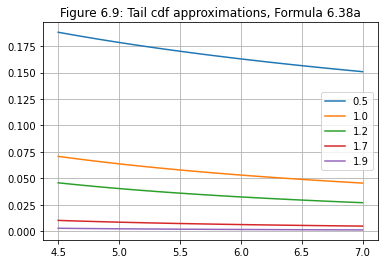

In [69]:
import scipy as sp
#Generate tail densities for various alpha's
#using formula 6.37a
x=np.arange(4.5,7.1,.1)
beta=0.0
gamma=1.0
alpha=[0.5,1.0,1.2,1.7,1.9]

for i,a in enumerate(alpha):
    tailscale=gamma**a
    tailscale*=np.sin(np.pi*a/2)
    tailscale*=sp.special.gamma(a)/np.pi
    tailscale*=(1+beta)
    row=[tailscale*x**(-a)]
    plt.plot(x,np.array(row[0]),label=str(a))

plt.grid()
plt.legend()
plt.title("Figure 6.9: Tail cdf approximations, Formula 6.38a")
plt.show;

## 6.5 Extreme Value Distributions
<a name="extreme_value_distributions"></a>

The [Central Limit Theorem](#central_limit_theorem) and the [Generalized Central Limit Theorem](#generalized_clt) addressed average values of random variables. In a financial context, averaging makes sense for quantities like log-returns: the annualized log-return over $n$ periods is the average of the $n$ per-period annualized log-returns. 

However there are other contexts where the "worst of" is of more concern than the "average of." A financial entity cannot continue operating for long if it can't pay its bills, so it has to assess the worst case for its assets versus its liabilities. Insurance companies can't just plan for average claims; they need an understanding of worst cases.

Thus, instead of thinking about $Average(X_1,X_2,\dots,X_n)$, at times we want to think about $Max(X_1,X_2,\dots,X_n)$, where the $X_i$ might be loss amounts or (minus) capital levels. If $X_1,X_2,\dots,X_n$ are i.i.d. with common cdf $F(x)$, then the maximum has a convenient distribution function: $Pr(Max(X_1,X_2,\dots,X_n)\leq x)=F^n(x)$.

For example, consider the uniform distribution $F(x)=x$ on $[0,1]$. Intuitively it's clear that the more points we sample from the uniform distribution, the higher the probability that the maximum is close to one. In fact we have $\mathbb{E}[Max(X_1,X_2,\dots,X_n)]=\int_0^1xdF(x)^n=\frac{n}{n+1}$ where the $X_i$ are iid uniformly distributed. A histogram of maxima from uniform samples shows that as expected the density function is proportional to $x^{n-1}$:

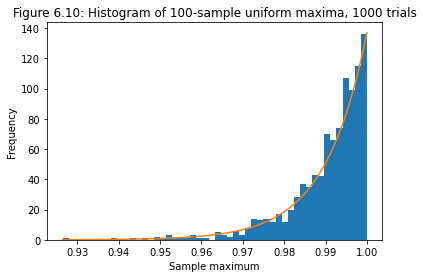

In [71]:
#Generate maxima of uniform samples
maxima=[]
n_sample, n_trials=100, 1000

rng = np.random.default_rng(111)   #Use seed so repeatable
maxima=np.amax(np.split(rng.uniform(size=n_sample*n_trials),n_trials),axis=1)

#generate histogram
n_per_bin, bins, patches = plt.hist(maxima, 50)

#generate theoretical density function; scale so area under curve = n_trials
y=bins**(n_sample-1)
y*=n_trials/sum(y)
    
plt.plot(bins, y)
plt.title("Figure 6.10: Histogram of "+str(n_sample)+"-sample uniform maxima, " \
          +str(n_trials)+" trials")
plt.xlabel("Sample maximum")
plt.ylabel("Frequency")
plt.show();

There is an analog to the [Central Limit Theorem](#central_limit_theorem) that says that if suitably normalized maxima converge, they converge to a particular type of distribution called a **`generalized extreme value (GEV) distribution`**. Standard (location 0, scale 1) GEV distributions can be parameterized with a scalar $\gamma$:
$$GEV_{\gamma}(x)=\exp\bigl(-(1+\gamma x)^{-1/\gamma}\bigr),\enspace1+\gamma x>0\label{eq:gev_general_cdf}\tag{6.50}$$
When $\gamma>0$, the GEV is also called a _Fr&eacute;chet distribution_; when $\gamma<0$ the GEV is also called a _Weibull distribution_. The limiting case $\gamma=0$ is called a _Gumbel distribution_:
$$GEV_0(x)=\exp\bigl(-exp(-x)\bigr)\label{eq:gumbel_cdf}\tag{6.51}$$

The associated pdfs are
$$gev_{\gamma}(x)=(1+\gamma x)^{-1/\gamma-1}GEV_{\gamma}(x),\enspace\gamma\neq0\label{eq:gev_not_zero_pdf}\tag{6.52a}$$
$$gev_0(x)=exp(-x)GEV_0(x)\label{eq:gev_zero_pdf}\tag{6.52b}$$

<a name="extreme_value_theorem"></a>The [Central Limit Theorem](#central_limit_theorem) analog is due to Fisher, Tippet and Gnedenko[$^{13}$](#six_footnotes), and says:
>**`Extreme Value Theorem`**: Suppose that $X_1,X_2,\dots$ are i.i.d and that there exist sequences $m_n$ and $s_n$ of constants and a nondegenerate cdf $G(x)$ so that
$$\lim_{n\to\infty}Pr\bigl(\frac{Max(X_1,X_2,\dots,X_n)-m_n}{s_n}\leq x\bigr)=G(x)\label{eq:evtheorem_limit}\tag{6.53}$$
Then $G(x)$ is a generalized extreme value (GEV) function as defined in \eqref{eq:gev_general_cdf}.

Here the degenerate cdfs being ruled out are those with 100% probability of a single outcome.

The condition in \eqref{eq:gev_general_cdf} shows that the support of Fr&eacute;chet distributions is bounded below by $-\frac{1}{\gamma}<0$, while the support of Weibull distributions is bounded above by $-\frac{1}{\gamma}>0$. Gumbel distributions have support across the entire real line.

A graph of the standard GEV pdf's with $\gamma=\pm.5$ is shown in Figure 6.11:

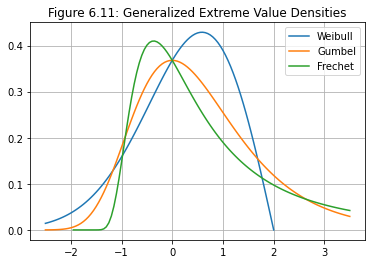

In [73]:
#Generate Weibull, Gumbel and Frechet densities
#using 6.52

def gev(gamma,x):
    #Return pdf of a gev with parameter gamma at point x
    if gamma != 0:
        op_gamma_x = 1 + gamma*x
        if op_gamma_x > 0:    #make sure in the support
            oo_gamma_power=op_gamma_x**(-1/gamma)
            gev_cdf=np.exp(-oo_gamma_power)
            gev_pdf=oo_gamma_power*gev_cdf/op_gamma_x
        else:
            gev_pdf = np.nan
    else:   #gumbel
        gev_cdf = np.exp(-np.exp(-x))
        gev_pdf = np.exp(-x)*gev_cdf
    return(gev_pdf)

gamma_list=[-0.5,0.0,.5]
name_list=['Weibull','Gumbel','Frechet']
x_list=np.arange(-2.5,3.55,.05)

for i,gamma in enumerate(gamma_list):
    y=[gev(gamma,x) for x in x_list]
    plt.plot(x_list,y,label=name_list[i])

plt.grid()
plt.legend()
plt.title('Figure 6.11: Generalized Extreme Value Densities')
plt.show();

Just as we did with stable distributions, we can introduce location and scale parameters to the standard GEV distributions. The general cdf is
$$GEV_{\mu,\sigma,\gamma}(x)=GEV_{\gamma}\bigl(\frac{x-\mu}{\sigma}\bigr)\label{eq:gev_general_general_cdf}\tag{6.55}$$
The general pdf is
$$gev_{\mu,\sigma,\gamma}(x)=\frac{1}{\sigma}gev_{\gamma}\bigl(\frac{x-\mu}{\sigma}\bigr)\label{eq:gev_general_general_pdf}\tag{6.56}$$

The additive location parameter $\mu$ and the multiplicative scale paramter $\sigma$ are not the mean and standard deviation of the distribution; in fact GEV's have no mean when $\gamma\geq1$. For a Gumbel distribution ($\gamma=0$), the mean is $\mu+\sigma K$ where $K\approx.577$ is Euler's constant $-\int_0^{\infty}exp(-x)ln(x)dx$.

Otherwise when $\gamma<1$, the mean of the GEV given by \eqref{eq:gev_general_general_pdf} is $\mu+\sigma(\Gamma(1-\gamma)-1)/\gamma$, where $\Gamma$ is the standard [Gamma function](#gamma_function).

### 6.5.1 Block Maxima

Estimating the parameters of a GEV is sometimes a difficult process. The **`method of block maxima`** is a simple approach; it's not the most efficient but it can give a quick start to understanding empirical data.

If we have $T$ observations, we can group the observations in $m$ blocks of $t$, where $mt\approx T$.

We'll compute block maxima for the 1971-present Swiss franc data that were analyzed in Figure 6.2. We could group the 12,000+ days of data into ten-day periods and form a histogram of the biggest loss in each ten-day period (changing signs so a loss is a positive number). The next cell does that and computes a histogram of outcomes. 

Worst observation: 0.08890689133141738
Best block: -0.0006642311768628944


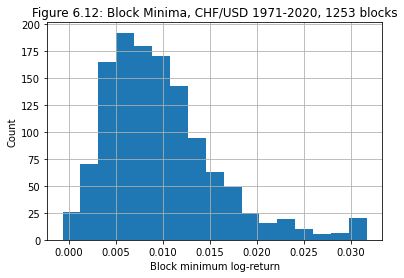

In [75]:
#Get block maxima (actually minima since looking for big losses) by
#grouping into 10-day blocks; using Swiss francs chf
blocksize=10; iblox=int(len(chf)/blocksize)
worstguys=-np.amin(np.split(np.array(chf[:iblox*blocksize]),iblox),axis=1)
    
#Plot a histogram of block maxima. histogram is
#Long-tailed to the right so have a "more" category
num_bins=int(np.sqrt(len(worstguys))/2)
#Winsorize so long tail doesn't give unrealistic scale of histogram.
#Winsorized values will show up in the highest bin of the histogram.
prettybad=np.percentile(worstguys,99)
sortaworst=[min(x,prettybad) for x in worstguys]

n, bins, patches = plt.hist(sortaworst, num_bins)
plt.title('Figure 6.12: Block Minima, CHF/USD 1971-' \
          +lastday[:4]+', '+str(len(worstguys))+' blocks')
plt.ylabel('Count')
plt.xlabel('Block minimum log-return')
plt.grid()
plt.show;
print('Worst observation:',np.max(worstguys))
print('Best block:',np.min(worstguys))

There was one ten-day period where all the log-returns were gains, so the maximum loss was negative. The worst 1% was forced into the bin starting at the 99th percentile because the positive tail is very long. It seems probable from the shape of the histogram in Figure 6.12 that the distribution is Fr&eacute;chet.

To determine best fit parameters, we can use a maximum likelihood method &mdash; that is, we maximize (over distribution parameters $\mu$, $\sigma$, $\gamma$) the product of the probability densities of the observations. As is often the case, it's more convenient to take the logarithm and maximize the sum, which we’ll call "LML" (Log-Maximum-Likelihood). Define $z_i=\frac{M_{t,i}-\mu}{\sigma}$. Then we have (using \eqref{eq:gev_general_general_pdf})
$$LML_{(\mu,\sigma,\gamma)}\bigl(M_{t,1},\dots,M_{t,m}\bigr)$$
$$=\ln{\bigl(\prod_{i=1}^m gev_{\mu,\sigma,\gamma}(M_{t,i})\bigr)}=-m\ln{(\sigma)}+\sum_{i=1}^m\ln{(gev_{\gamma}(z_i))}\tag{6.57}$$

We can further define $y_i=1+\gamma z_i$ and state
$$LML_{(\mu,\sigma,\gamma)}\bigl(M_{t,1},\dots,M_{t,m}\bigr)=-m\ln{(\sigma)}-(1+1/\gamma)\sum_{i=1}^n\ln{(y_i)}-\sum_{i=1}^m y_i^{-1/\gamma},\enspace\gamma\neq0$$
$$LML_{(\mu,\sigma,\gamma)}\bigl(M_{t,1},\dots,M_{t,m}\bigr)=-m\ln{(\sigma)}-\sum_{i=1}^m z_i-\sum_{i=1}^m\exp{(-z_i)},\enspace\gamma=0\tag{6.58}$$

A nonlinear optimizer can be used to find the parameters, although the optimization can be unstable.

A simple heuristic is to find the parameters that minimize the [Q-Q plot](#q-q-plots) distance. That is, assume our maxima observations are sorted so that $M_{t,1}\leq M_{t,2}\leq\dots\leq M_{t,m}$. Then find the parameters $\mu$, $\sigma$, $\gamma$ that minimize
$$\sum_{i=1}^m\bigl(\frac{i}{m+1}-GEV_{(\mu,\sigma,\gamma)}\bigl(M_{t,i}\bigr)\bigr)^2\label{eq:gev_q_q}\tag{6.59}$$

Figure 6.13 is the Q-Q plot that results from using the scipy.stats best fit function for the Swiss franc block maxima data.

Gamma= 0.09702171318675068
Mu= 0.006984180180882179
Sigma= 0.004346412102372856


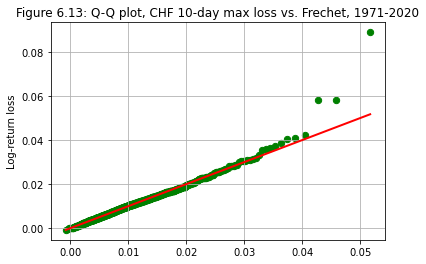

In [78]:
#Find the best fit extreme value distribuion to CHF block maxima

xsample=np.sort(worstguys)
m_sample=len(xsample)
ysample=[(i+1)/(m_sample+1) for i in range(m_sample)]

#Use scipy.stats.genextreme to fit - "c" parameter is minus gamma in our notation
fit_params = spst.genextreme.fit(xsample)
if fit_params[0]<0:
    dist_name="Frechet"
elif fit_params[0]==0:
    dist_name="Gumbel"
else:
    dist_name="Weibull"

gma=-fit_params[0]; mu=fit_params[1]; sigma=fit_params[2]    
    
print("Gamma=",gma)    
print("Mu=",mu)
print("Sigma=",sigma)

#Make the Q-Q plot of extremes versus the best fit distribution
#Inverse cumulative distribution of a probability p is:
#sigma*{((-ln(p))^(-gma)-1)/gma}+mu
#Equally spaced p's are in ysample. Don't have to worry about gma=0 due to sampling noise
xgenex=(-np.log(ysample))**(-gma)-1
xgenex*=sigma/gma
xgenex+=mu
#Plot the diagonal
line=plt.plot(xgenex,xgenex)
plt.setp(line, linewidth=2, color='r')
#Plot the actuals
plt.scatter(xgenex,xsample, s=40, c='g')
tstr='Figure 6.13: Q-Q plot, CHF %d-day max loss vs. ' % blocksize
tstr+=dist_name+', '+lgdates[0][:4]+'-'+lastday[:4]
plt.title(tstr)
plt.ylabel('Log-return loss')
plt.grid(True)
plt.show;

Except for three outlying values, the Q-Q plot in Figure 6.13 is reasonably straight as desired.

If the [Extreme Value Theorem]() holds, then the $\gamma$ we obtain from block maxima is expected to be the same (except for sampling error) across all block sizes $t$. $\mu$ and $\sigma$ will vary as the block size changes.

### 6.5.2 Domains of Attraction
<a name="domains_of_attraction"></a>

We could restate the conclusion of the Extreme Value Theorem \eqref{eq:evtheorem_limit} as:
$$\lim_{n\to\infty}\bigl[F^n(s_n x + m_n)\bigr]=GEV_{\gamma}(x)\label{eq:evtheorem_power}\tag{6.70}$$

Consider for example the exponential distribution whose cdf is $F(x)=1-\exp(-\lambda x)$ for $x\geq0$ and a parameter $\lambda>0$. The pdf is $\lambda \exp(-\lambda x)$, so the mean $\mu$ equals the standard deviation $\sigma$; both are $1/\lambda$. If in \eqref{eq:evtheorem_power} we set $s_n=\sigma=1/\lambda$ and $m_n=(\ln{n})\mu$, then we have
$$\lim_{n\to\infty}\bigl[F^n(s_n x + m_n)\bigr]=\lim_{n\to\infty}\bigl[\bigl(1-\exp(-\lambda(s_n x + m_n))\bigr)^n\bigr]$$
$$=\lim_{n\to\infty}\bigl[\bigl(1-\exp(-(x + \ln{n}))\bigr)^n\bigr]=\lim_{n\to\infty}\bigl[\bigl(1-\frac{e^{-x}}{n}\bigr)^n\bigr]=GEV_0(x)\label{eq:domain_exponential}\tag{6.71}$$
So maxima of exponential distributions are Gumbel distributed.

Generally we say that a cdf $F$ is in the **`maximum domain of attraction`** of a GEV distribution with parameter $\gamma$ if, when we apply the Extreme Value Theorem \eqref{eq:evtheorem_limit} to maxima of $F$, the result is $GEV_{\gamma}$. In that case we write $F\in MDA(GEV_{\gamma})$. Thus we've just shown that the exponential distribution is in $MDA(GEV_0)$.

For the uniform distribution $F(x)=x$ on $[0,1]$, we saw [above](#extreme_value_distributions) that  $m_n=\frac{n}{n+1}$ was probably a good choice. Set $s_n=\frac{1}{n+1}$. Then
$$\lim_{n\to\infty}\bigl[F^n(s_n x + m_n)\bigr]=\lim_{n\to\infty}\bigl[\bigl(\frac{x+n}{n+1}\bigr)^n\bigr]
=\lim_{n\to\infty}\bigl[\bigl(1+\frac{x-1}{n+1}\bigr)^n\bigr]=\exp(-(1-x))=GEV_{-1}(x)$$
The uniform distribution is in $MDA(GEV_{-1})$, i.e. the Weibull family.

If $F(x)$ is normal as in \eqref{eq:lyapunov_limit}, it is in $MDA(GEV_0)$, i.e. the Gumbel family. [One standardizing sequence](https://doi.org/10.1016/j.jmaa.2014.08.025) &mdash; there are others &mdash; is $m_n=F^{-1}(1-\frac{1}{n})$ and $s_n=\frac{m_n}{1+m_n^2}$. Thus
$$F^n(y)=\exp{\left(-\exp{\left(\frac{y-m_n}{s_n}\right)}\right)}=\exp{\left(-\exp{\left(-(m_n+\frac{1}{m_n})y-(m_n^2+1)\right)}\right)}$$
Recall that the mean of a translated Gumbel distribution is $m_n+s_n K$ where $K\approx.577$ is Euler's constant. This shows that normal maxima increase very slowly: $m_n=10$ when $n$ is about $10^{23}$. Thus in order to get an expected maximum of a little more than $10$, the sample size has to be about $10^{23}$.

Necessary and sufficient conditions are known for the parameter of the MDA family if one exists:

If $F$ is a cdf where $F(x)<1$ for all finite $x$, then $F\in MDA(GEV_{\gamma})$ for $\gamma>0$ (i.e. a Fr&eacute;chet distribution) if and only if
$$\lim_{t\to\infty}\frac{1-F(tx)}{1-F(t)}=x^{-1/\gamma}$$

The $\gamma<0$ (Weibull) case is similar. Define $x_{sup}=\sup\{x:F(x)<1\}$. If $x_{sup}<\infty$, then $F(x)\in MDA(GEV_{\gamma})$ for $\gamma<0$ if and only if
$$\lim_{t\to\infty}\frac{1-F(x_{sup}-\frac{1}{tx})}{1-F(x_{sup}-\frac{1}{t})}=x^{1/\gamma}$$

The conditions for Gumbel ($\gamma=0$) distributions are more technical.

## 6.6 Tail Distributions

The methods we have just discussed for estimating Generalized Extreme Value distributions may be helpful in thinking about protecting something: a bank's capital; an insurance company's ability to cover a disaster; a hedge fund's ability to operate; a long-only asset manager's relationship with its clients. With an estimate of the distribution of maximum losses, a risk manager can take steps &mdash; setting aside a buffer, buying put options, reinsuring, changing positions &mdash; so the enterprise can continue to operate.

While the distribution of maximum losses is one important characteristic of the tails of a distribution, estimating the behavior of the tail distribution itself can also be of interest. That is, contingent on being beyond some point $u$ in the support of a distribution, what does the rest of the distribution look like? This can be of interest to a reinsurer, who covers losses over a certain amount.

If $F(x)$ is a cdf, the **`excess or tail distribution`** $F_u(x)$ is:
$$F_u(x)=Pr(X-u\leq x\mid X>u)=\frac{F(x+u)-F(u)}{1-F(u)}\tag{6.80}$$

The denominator is necessary to normalize $F_u(x)$ so it ranges from 0 to 1 as $x$ ranges from $0$ to $\infty$. The graph plotted in the next cell shows the tail distributions based on a standard normal distribution for u=2,3,4,5.

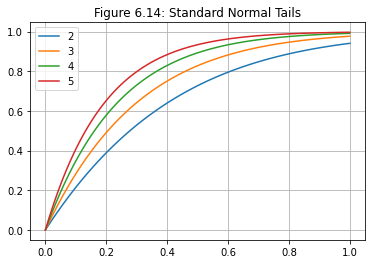

In [79]:
#Generate normal tails according to 6.80
xlist=np.arange(0,1.01,.01)
ulist=[2,3,4,5]

for u in ulist:
    fofu=spst.norm.cdf(u)
    y=[(spst.norm.cdf(x+u)-fofu)/(1-fofu) for x in xlist]
    plt.plot(xlist,y,label=str(u))

plt.grid()
plt.legend()
plt.title('Figure 6.14: Standard Normal Tails')
plt.show();

We can see that $F_u$ [stochastically dominates](#stochastic_dominance) $F_v$ if $u<v$; the further out in the tail we are, the faster the cdf rises at the beginning.

There is a third natural class of distributions called **`Generalized Pareto Distributions (GPDs)`** that, like stable and GEV distributions, are the limiting values of certain behaviors. Stable distributions are the limiting values of sums (or averages after normalization); GEV's are the limiting values of maxima; and GPD's are the limiting values of tail distributions
${lim}_{u\to m_F}F_u(x)$ where $m_F=max\{x\in domain(F)\}$. They have this form:

$$GPD_{\gamma,\beta}(x)=1-(1+\frac{\gamma x}{\beta})^{-1/\gamma},\enspace\gamma\neq0$$
$$GPD_{0,\beta}(x)=1-exp\bigl(-\frac{x}{\beta}\bigr)\label{eq:gpd_definition}\tag{6.81}$$

Here $\beta>0$. The support $supp(GPD_{\gamma,\beta})=[0,m_F)$ where $m_F=\infty$ if $\gamma\geq0$, and $m_F=-\frac{\beta}{\gamma}$ otherwise.

Using the exponential distribution $F(x)=1-\exp{(-\lambda x)}$ as an example, we see that
$$F_u(x)=\frac{1-\exp{(-\lambda (x+u))}-(1-\exp{(-\lambda u)})}{1-(1-\exp{(-\lambda u)})}
=\frac{\exp{(-\lambda (x+u))}-\exp{(-\lambda u)}}{\exp{(-\lambda u)}}=F(x)$$

So (unlike the normal distribution) the exponential distribution doesn’t care where in the tail it is &mdash; the tail distribution equals the distribution. Also note that $F(x)=GPD_{\gamma,\beta}(x)$ where $\gamma=0$ and $\beta=1/\lambda$.

Thus the tail distribution of a GPD with $\gamma=0$ is also a GPD with $\gamma=0$. This property holds as well for $\gamma\neq0$. If $F(x)=GPD_{\gamma,\beta}(x)$, then
$$F_u(x)=\frac{-\bigl(1+\frac{\gamma(x+u)}{\beta}\bigr)^{-\frac{1}{\gamma}}+\bigl(1+\frac{\gamma u}{\beta}\bigr)^{-\frac{1}{\gamma}}}{\bigl(1+\frac{\gamma u}{\beta}\bigr)^{-\frac{1}{\gamma}}}=1-\bigl(1+\frac{\gamma x}{\beta+\gamma u}\bigr)^{-1/\gamma}=GPD_{\gamma,\beta+\gamma u}(x)$$
The tail GPD has the same parameter $\gamma$, but shifts the scale parameter from $\beta$ to $\beta+\gamma u$.

We saw in \eqref{eq:domain_exponential} that the exponential distribution was in $MDA(GEV_0)$. We saw above that the tail behavior of the exponential was $GPD_{0}$. That's not a coincidence:<a name="pickands_theorem"></a>
>**`Theorem (Pickands)`**: If (and only if) $F(x)\in MDA(GEV_{\gamma})$, then there exists a function $\beta(u)$ such that
$$\underset{u\to m_F}\lim\underset{x<m_F-u}\sup\bigl|F_u(x)-GPD_{\gamma,\beta(u)}(0)\bigr|=0\label{eq:pickands}\tag{6.85}$$
where $\max\{x\in domain(F)\}=m_F$.

Pickands Theorem ties together maximum behavior and tail behavior through the parameter $\gamma$ &mdash; if a distribution $F$ has maxima that approach $GEV_{\gamma}$, then its tail distribution approaches (in the way shown in \eqref{eq:pickands}, as the threshold u is raised in the limit as far as it can go) the $GPD_{\gamma}$ family. And vice versa.

### 6.6.1 Fitting Parameters to Tail Distributions

Unfortunately in practice it is often difficult to collect enough data to estimate the relevant parameters. By definition, tail phenomena occur rarely. Imposing a model or borrowing data from other markets can help, but ultimately judgment needs to be used.

Despite the difficulty of this problem, we'll try to apply the framework we've just seen in practice. Let $F(x)$ be a cdf with support on the real line up to $m_F$. We'll make these heroic[$^{14}$](#six_footnotes) assumptions:
- The [Extreme Value Theorem](#extreme_value_theorem) applies so that $F\in MDA(GEV_{\gamma})$ for some $\gamma$.
- [Pickands Theorem](#pickands_theorem) then applies and we are far enough along into the tail that the limit \eqref{eq:pickands} is a reasonable description of tail behavior.

To implement these assumptions, samples are taken from the distribution $F$, say $X_1,\dots,X_T$. Then the **`exceedance set`** $EX_u(X_1,\dots,X_T)=\{Y_i=X_i-u \mid X_i\geq u\}$ is formed. These are the overages of the set of observations that are beyond the threshold $u$. For an insurance company $u$ might be the deductible on an insurance policy, or the amount it has reinsured with other insurance companies &mdash; in that case the exceedance set contains the amounts the insurance company will actually have to pay. Similarly tranches of structured financial products may only be affected by exceedances of their subordination.

The **`exceedance count`** $EC_u$ is the number of items in the exceedance set $EX_u$. We will leave out the arguments $X_1,\dots,X_T$ when it is clear what they are. They are sometimess used as risk metrics, but exceedance counts suffer from lack of [coherence](#coherent_risk) in a way that is similar to [Value at Risk](#value_at_risk) &mdash; they don't provide much information on how bad things can get in the tail.

The **`peaks over thresholds ("POT")`** method is the application of Pickands Theorem in this situation. The POT method entails choosing a cutoff point $u$ and then finding the parameters of a Generalized Pareto Distribution (GPD) that best fit the exceedance set. A large body of literature addresses methods to find good cutoff points $u$ and good parameter estimates; [Goldberg and Giesecke 2004](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=624766) give a good overview.

We'll use a standard log-maximum-likelihood method for our parameter estimation. This involves multiplying together the probability densities of observing the exceedances and taking the logarithm. Taking the derivative of \eqref{eq:gpd_definition} gives
$$gpd_{\gamma,\beta}(x)=\frac{1}{\beta}\bigl(1+\frac{\gamma x}{\beta}\bigr)^{-1/\gamma-1},\enspace\gamma\neq0$$
$$gpd_{0,\beta}(x)=\frac{1}{\beta}\exp{\bigl(-\frac{x}{\beta}\bigr)}\label{eq:gpd_density}\tag{6.86}$$

As Figure 6.15 shows, there is ugly behavior when $\gamma<-1$: the pdf blows up as $x$ approaches the upper limit $m_F=-\beta/\gamma$ of the support. Maximum likelihood becomes problematic. Fortunately most real data seems to have $\gamma>-1$.

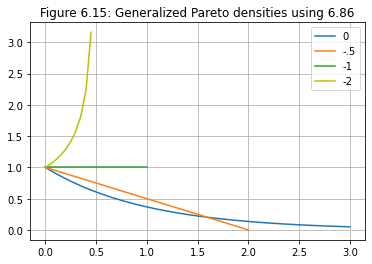

In [81]:
#Create Generalized Pareto densities using 6.86
xlist=np.arange(0,3.05,.05)

#gamma=0; density is exp(-x)
plt.plot(xlist,[np.exp(-x) for x in xlist],label='0')

#gamma=-.5; upper limit is 2
shortlist=np.arange(0,2.05,.05)
y=[1-x/2 for x in shortlist]
y+=[np.nan]*(len(xlist)-len(shortlist))
plt.plot(xlist,y,label='-.5')

#gamma=-1; constant value of 1 up to 1
shortlist=np.arange(0,1.05,.05)
y=[1]*len(shortlist)
y+=[np.nan]*(len(xlist)-len(shortlist))
plt.plot(xlist,y,label='-1')

#gamma=-2; blows up at x=.5
#1/sqrt(1-2x)
shortlist=np.arange(0,.5,.05)
y=[1/(1-2*x)**.5 for x in shortlist]
y+=[np.nan]*(len(xlist)-len(shortlist))
plt.plot(xlist,y,label='-2',color='y')

plt.grid()
plt.legend()
plt.title('Figure 6.15: Generalized Pareto densities using 6.86')
plt.show();

To find $\gamma$ and $\beta$ from observed data $X_1,\dots,X_n$, the log-likelihood function is maximized:
$$LML_{\gamma,\beta}(EX_u(X_1,\dots,X_n))=-EC_u \ln{(\beta)}+\sum_{Y_i\in EX_u(X_1,\dots,X_n)}\ln{(gpd_{\gamma,\beta}(Y_i)})$$
$$=-EC_u \ln{(\beta)}-\bigl(1+\frac{1}{\gamma}\bigr)\sum_{Y_i\in EX_u(X_1,\dots,X_n)}\ln{\bigl(1+\gamma\frac{Y_i}{\beta}\bigr)},\enspace\gamma\neq0$$
$$=-EC_u\bigl(\ln{(\beta)}+\frac{\bar{Y}}{\beta}\bigr),~\gamma=0\label{eq:gpd_lml}\tag{6.87}$$
where $\bar{Y}$ is the average value of the nonzero exceedances $Y_i$. For the Gumbel family ($\gamma=0$), this shows that the maximum value of the log-likelihood function occurs when $\beta=\bar{Y}$.

For an example, we'll use draws from a standard normal distribution. We know from [above](#domains_of_attraction) that the normal is in $MDA(GEV_0)$, i.e. the Gumbel family. So from [Pickands Theorem](#pickands_theorem) we know that the tails should approach an exponential distribution ($GPD_0$ as in \eqref{eq:gpd_definition}). Thus we should find that the maximum likelihood occurs when $\gamma=0$ and $\beta=\bar{Y}$, the average exceedance.

In [82]:
#Generate 10,000 standard normal draws
#Take exceedances over threshold; show number and average exceedance
threshold=2
n_sample=10000

rng = np.random.default_rng(314159)   #Use seed so repeatable
sample = rng.normal(size=n_sample)

exceeds=[s-threshold for s in sample if s>threshold]  #Exceedance set over u=threshold

numex=len(exceeds)    #exceedance count
#Theoretical exceedance count
theo_numex=int(n_sample*spst.norm.cdf(-threshold)+.5)

avex=np.mean(exceeds) #y-bar
#Theoretical average exceedance
theo_avex=np.exp(-threshold)/((1-spst.norm.cdf(threshold))*np.sqrt(2*np.pi))-threshold

#Sample maximum likelihood function 6.87
maxlike=-numex*(np.log(avex)+1)
#Theoretical maximum likelihood function
theo_maxlike=-theo_numex*(np.log(theo_avex)+1)

print('Sample number of exceedances over {0}: {1}'.format(threshold,numex))
print('Theoretical number of exceedances: {0}'.format(theo_numex))
print('\nSample average exceedance:',avex)
print('Theoretical average exceedance:',theo_avex)
print('\nSample maximum likelihood function at beta: {0}'.format(maxlike))
print('Theoretical maximum likelihood function at beta: {0}'.format(theo_maxlike))

Sample number of exceedances over 2: 236
Theoretical number of exceedances: 228

Sample average exceedance: 0.35425370003744094
Theoretical average exceedance: 0.37321553282284103

Sample maximum likelihood function at beta: 8.907101559107904
Theoretical maximum likelihood function at beta: -3.2833846264013493


There were more exceedances than the $10000\cdot F_{norm}(-2)=228$ than were expected simply due to sampling error. Sampling error has a comparatively small effect on the number of exceedances and on the average exceedance, but has a large effect on the (unfortunately) sensitive maximum likelihood function.

The code segment performs the LML optimization without forcing $\gamma=0$:

In [83]:
import scipy.optimize as scpo

#Log-max-likelihood for GPD. Sign is reversed since we are using minimize.
def gpd_lml(params):
    gma,beta_log=params
    #enforce positive beta
    beta=np.exp(beta_log)
    #check if gamma=0
    tolerance=10**(-9)
    if abs(gma)<tolerance:
        return(numex*(beta_log+avex/beta))
    #uses "exceeds" vector computed above
    log_sum=0
    #sum ln(1+gamma*yi/beta) when positive
    for i in range(numex):
        arg_log=1+gma*exceeds[i]/beta
        if arg_log<=0:
            log_sum+=1000*np.sign(1+1/gma)  #put a very discouraging amount in the sum
        else:
            log_sum+=np.log(arg_log)
    #scale
    log_sum*=(1+1/gma)
    if beta<=0:
        log_sum+=1000
    else:
        log_sum+=numex*np.log(beta)
    return(log_sum)

#initial guess for parameters is gumbel
init_params=[0.,np.log(avex)]
#Run the minimization.
results = scpo.minimize(gpd_lml,
                            init_params,
                            method='CG')
gma_res,beta_res=results.x
beta_res=np.exp(beta_res)   #move back from log space

print("Optimal gamma:",gma_res)
print("Optimal beta:",beta_res)
print("Support cap mF:",-beta_res/gma_res)
print("Optimal LML:",-results.fun)

Optimal gamma: -0.12229649326542354
Optimal beta: 0.39723275375440636
Support cap mF: 3.2481123795780547
Optimal LML: 10.744930456472616


The optimization process returns a Weibull ($\gamma<0$) distribution, even though the data was generated by sampling a normal distribution which we know to be in the Gumbel MDA family. This gives an idea of the confidence interval around parameter estimates.

Figure 6.16 shows that both the theoretically appropriate Gumbel distribution and the LML-optimal Weibull distribution do a good job of fitting the empiricals.

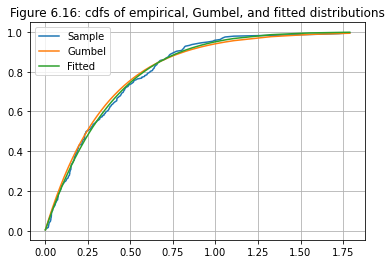

In [85]:
#Show the CDF plot
#x's are sorted values of the exceedances
xsample=np.sort(exceeds)
ysample=[(i+1)/(numex+1) for i in range(numex)]
ygumbel=[1-np.exp(-x/avex) for x in xsample]
yfitted=[1-(1+gma_res*x/beta_res)**(-1/gma_res) for x in xsample]

plt.plot(xsample,ysample,label='Sample')
plt.plot(xsample,ygumbel,label='Gumbel')
plt.plot(xsample,yfitted,label='Fitted')

plt.grid()
plt.legend()
plt.title('Figure 6.16: cdfs of empirical, Gumbel, and fitted distributions')
plt.show;

A similar result is obtained using the scipy.stats Generalized Pareto application:

In [86]:
#Find the best fit generalized pareto distribuion to normal extrema

xsample=np.sort(exceeds)
m_sample=len(xsample)
ysample=[(i+1)/(m_sample+1) for i in range(m_sample)]

#Use scipy.stats.genpareto to fit
#The fit also finds a location parameter mu
gma_spst, mu_spst, beta_spst = spst.genpareto.fit(xsample,gma_res)

print("scipy.stats optimal gamma, (6.87) gamma:",gma_spst,gma_res)
print("scipy.stats optima mu, (6.87) mu:",mu_spst,0.)
print("scipy.stats optimal beta, (6.87) beta:",beta_spst,beta_res)

scipy.stats optimal gamma, (6.87) gamma: -0.11828514339286177 -0.12229649326542354
scipy.stats optima mu, (6.87) mu: 0.0018525166876476764 0.0
scipy.stats optimal beta, (6.87) beta: 0.393752301002408 0.39723275375440636


The genpareto.fit algorithm solves for a location parameter $\mu$ that we didn't include; the value is close to zero, and the $\gamma$ and $\beta$ parameters are close to the ones from our maximum likelihood method. 

# Chapter 6 Footnotes
<a name="six_footnotes"></a>

$^1$ Benoit Mandlebrot gives credit to a variety of earlier writers for noticing departures from normality, going as far back as Wesley C. Mitchell in 1915.
<br>

$^2$ Rick Durett, _Probability: Theory and Examples_, Edition 4.1 (2013, Cambridge University Press), p. 113 (available on https://services.math.duke.edu/~rtd/PTE/PTE4_1.pdf)
<br>

$^3$ Durett, p. 118. We have modified Durett's version to allow for non-identical distributions.
<br>

$^4$ Durett, p. 194.
<br>

$^5$ The [age of the universe](https://dx.doi.org/10.1088/0067-0049/192/2/14) is about 13.75 billion years, which is about $10^{13}$ business days.
<br>

$^6$ Homer and Sylla indicate that Sumerian agricultural loans from about 4 millenia ago are the oldest ones recorded. They document interest rates century by century to the present, but there does not appear to be another entity that has as long an unbroken record of non-defaulting borrowing as the UK government.Homer, Sidney and Sylla, Richard, _A History of Interest Rates, 4th Edition_, Wiley Finance: August 2005. ISBN: 978-0-471-73283-9.
<br>

$^7$ Braudel finds securities being exchanged in Italian city-states in the early 1300s, but these markets have not operated continuously. Braudel, Fernand (Si&acirc;n Reynold, tr.), _Civilization and Capitalism 15th-18th Century Volume II: The Wheels of Commerce_, University of California Press, 1992, pp. 97-99. https://www.ucpress.edu/book/9780520081154/civilization-and-capitalism-15th-18th-century-vol-ii
<br>

$^8$ Carmen Reinhart and Kenneth Rogoff, _This Time Is Different: Eight Centuries of Financial Folly_, Princeton University Press, 2009. https://press.princeton.edu/titles/8973.html
<br>

$^9$ Visit http://www.americanbondholdersfoundation.com/ to see a group of people (or their descendants) who bought Chinese government bonds pre-1938 and are still trying to get their money back. The Shanghai stock exchange also closed in 1949. It re-opened in 1990 with completely new listings.
<br>

$^{10}$ In this section we have relied on John P. Nolan's [Stable Distributions: Models for Heavy-Tailed Data](http://academic2.american.edu/~jpnolan) and a prepublication version of Nair, Wierman, and Zwart's [Fundamentals of Heavy Tails](https://docs.google.com/forms/d/e/1FAIpQLSdd4YH248k0yKMHVsKG3syGZXwnREF-1k7LTd7iU01Y_nfWlQ/viewform?usp=sf_link).
<br>

$^{11}$ There are so many parameterizations of stable distributions that some authors include a fifth parameter indicating which parameterization scheme is being used. We have adopted the main scheme used by [Nolan](http://academic2.american.edu/~jpnolan).
<br>

$^{12}$ Nolan, Theorem 1.12.
<br>

$^{13}$ Myriam Charras-Garrido, Pascal Lezaud. Extreme Value Analysis: An Introduction. Journal de La Societe Fran&ccedil;aise de Statistique, 2013, 154(2), pp. 67-97. https://hal-enac.archives-ouvertes.fr/hal-00917995
<br>

$^{14}$ "Heroic" assumptions are likely to be violated in practice, but are made nonetheless to guide thinking.